In [2]:
from bauer.utils.data import load_garcia2022
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op    
import os


bids_folder = '/Users/mrenke/data/ds-miguel'
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels_risk')

df = load_garcia2022(task='risk')
dataset = 'MiguelsData'

df['n_risky'] = np.where(df['p1']==0.55,df['n1'], df['n2'])
df['n_safe'] = np.where(df['p1']==1,df['n1'], df['n2'])

In [5]:
# for debugging, compare to numrisk dataframe

from utils import get_data

df = get_data('/Users/mrenke/data/ds-dnumrisk') # debug
dataset = 'dyscalculiaData'
df.set_index('n_safe', append=True, inplace=True)   


number of subjects in dataframe: 66
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_5374/3625103660.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = df.groupby(['n_safe', 'format','group']).mean()


['n_safe range: ', array([ 7.,  5., 10., 14., 20., 28.])]
['n_risky mu & sd: ', 32.620881966298846, 24.00049873800702]


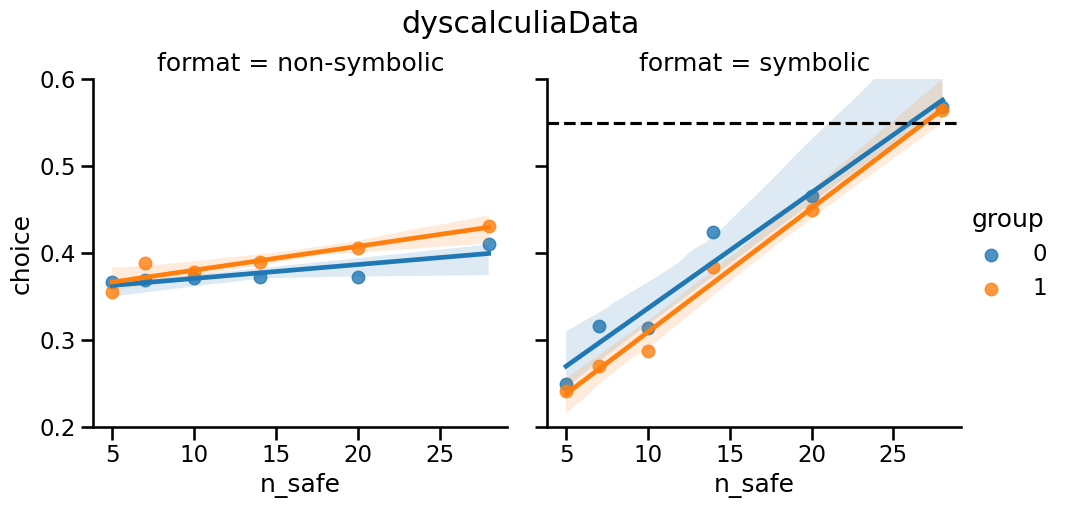

In [22]:
import seaborn as sns
sns.set_context('talk')

temp = df.groupby(['n_safe', 'format','group']).mean()

ax = sns.lmplot(data=temp.reset_index(), x='n_safe', y='choice', hue='group',col='format')
ax.set(ylim=[0.2,0.6])
ax.fig.suptitle(dataset, y=1.03)

plt.axhline(0.55, ls='--', color='black')

print(['n_safe range: ', df.reset_index()['n_safe'].unique()])
print(['n_risky mu & sd: ', df.reset_index()['n_risky'].mean(), df.reset_index()['n_risky'].std()])


['n_safe range: ', array([14,  5, 10, 28, 20,  7])]
['n_risky mu & sd: ', 31.40539738048893, 23.45520202524752]


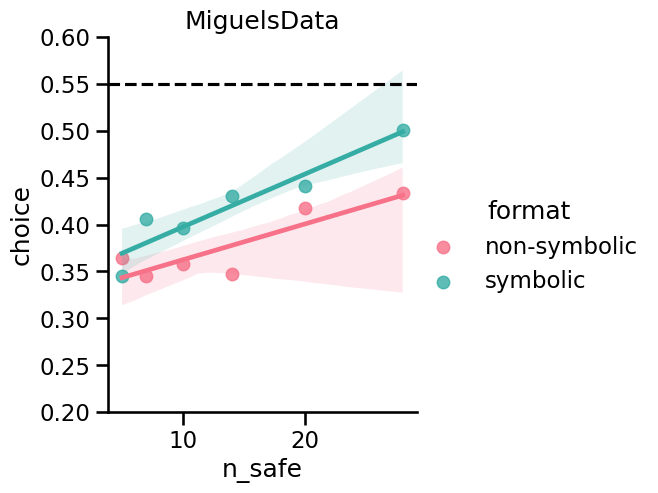

In [7]:
import seaborn as sns
sns.set_context('talk')

temp = df.groupby(['n_safe', 'format']).mean()

ax = sns.lmplot(data=temp.reset_index(), x='n_safe', y='choice', hue='format',palette='husl')
ax.set(ylim=[0.2,0.6],  title=dataset)
plt.axhline(0.55, ls='--', color='black')

print(['n_safe range: ', df.reset_index()['n_safe'].unique()])
print(['n_risky mu & sd: ', df.reset_index()['n_risky'].mean(), df.reset_index()['n_risky'].std()])


## Probit model (stake size?)

In [ ]:
import bambi
import arviz as az


model_label = 2
format = 'symbolic'
data = df.xs(format, 0, level='format')
data['x'] = data['log(risky/safe)'] 
data['chose_risky'] = data['choice'] 

model = bambi.Model('chose_risky ~ x + x*n_safe + (x*n_safe|subject)', link='probit', family='bernoulli', data=data.reset_index())


In [ ]:
# fitting only works with behav_fit2_clone/copy env, but not in VSCode notebook interface....

traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)
az.to_netcdf(traces, op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))

2 symbolic
Intercept: mean=-3.197033563369795, 95%CI=[-3.6369317  -2.78035228]
x: mean=3.2233755136667894, 95%CI=[2.71151023 3.75595333]
n_safe: mean=-0.02517408388195068, 95%CI=[-0.04502986 -0.00639276]
x:n_safe: mean=0.09039472387274543, 95%CI=[0.06332941 0.11927467]


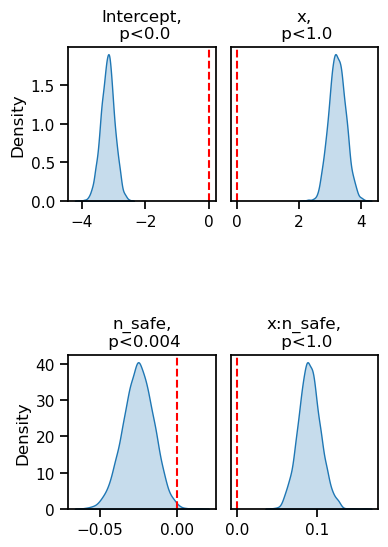

In [4]:
traces = az.from_netcdf( op.join(target_folder, f'rnp_model-{model_label}_format-{format}_trace.netcdf'))

print(model_label, format)
sns.set_context('notebook')

variable_names = list(traces.posterior.data_vars.keys())  # variable_names = list(traces.posterior.data_vars.keys()) 
variable_names = [x for x in variable_names if 'subject' not in x] # remove sd

n_rows = int(len(variable_names) / 2 )
fig, axs = plt.subplots(n_rows,2, figsize=(4,6), sharex=False)

for i in range(n_rows):
    for j in range(2): # intercept & slope 
        index = i * 2 + j
        var = variable_names[index] # goes till 7/8
        temp = traces.posterior[var].to_dataframe()
        count_greater_zero = np.round(np.mean(temp[var] > 0),3)
        sns.kdeplot(temp, ax=axs[i, j],legend=False, fill=True)
        if j!= 0:
            axs[i, j].set(yticks=[],ylabel='')
        axs[i, j].axvline(x=0, color='r', linestyle='--')
        axs[i, j].set_title(f'{var},\n p<{count_greater_zero}')
        print(f'{var}: mean={temp[var].mean()}, 95%CI={np.percentile(temp[var], [2.5, 97.5])}')

fig.subplots_adjust(wspace=0.1, hspace=1)
#plt.savefig(op.join(plot_folder, f'rnp_model-{model_label}_format-{format}_regressors.pdf'))

In [7]:
data.head()

p1  n1    p2  n2  log(risky/safe)  choice  n_risky  \
subject run trial_nr                                                        
1       1   1         1.0  14  0.55  47         1.211090    True       47   
            2         1.0   5  0.55   6         0.182322   False        6   
            3         1.0  14  0.55  17         0.194156   False       17   
            4         1.0  10  0.55  12         0.182322   False       12   
            5         1.0  14  0.55  28         0.693147    True       28   

                      n_safe         x  chose_risky  
subject run trial_nr                                 
1       1   1             14  1.211090         True  
            2              5  0.182322        False  
            3             14  0.194156        False  
            4             10  0.182322        False  
            5             14  0.693147         True

In [10]:
import pandas as pd
import scipy.stats as ss

def invprobit(x):
    return ss.norm.ppf(x)

def extract_rnp_precision(trace, model, data, format=True,  group_level = False):

    data = data.reset_index()

    reg_list = [data.reset_index()['subject'].unique(),[0, 1], data['n1'].unique()]
    names=['subject', 'x', 'n_safe']

    if format:
        reg_list.append(data['format'].unique())
        names.append('format')

    if group_level: # needed 
        include_group_specific = None
    else:     # when no subjects! include_group_specific=False
        include_group_specific = True 

    fake_data = pd.MultiIndex.from_product(reg_list,names=names).to_frame().reset_index(drop=True)

    pred = model.predict(trace, 'mean', fake_data, inplace=False, include_group_specific=include_group_specific)['posterior']['chose_risky_mean']

    pred = pred.to_dataframe().unstack([0, 1])
    pred = pred.set_index(pd.MultiIndex.from_frame(fake_data))

    # return pred

    pred0 = pred.xs(0, 0, 'x')
    intercept = pd.DataFrame(invprobit(pred0), index=pred0.index, columns=pred0.columns)
    gamma = invprobit(pred.xs(1, 0, 'x')) - intercept

    return intercept, gamma

In [11]:
intercept, gamma = extract_rnp_precision(traces, model, data, format=False, group_level = False)
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

gamma = gamma.stack([1,2])
gamma.columns = ['gamma']

intercept = intercept.stack([1,2])
intercept.columns = ['intercept']

/Users/mrenke/mambaforge/envs/behav_fit2_copy/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [13]:
from itertools import product

n_chains = rnp.index.unique('chain').values
n_draws = rnp.index.unique('draw').values

index = pd.MultiIndex.from_product([n_chains, n_draws], names=['chain', 'draw'])

# get general stake-size:RNP effect

df_ss_rnp = pd.DataFrame(index=index, columns=['slope', 'intercept'])

for chain, draw in product(n_chains, n_draws):
    rnp_sample = rnp.xs(chain, level='chain').xs(draw, level='draw').reset_index('n_safe')

    tmp = rnp_sample#.xs(0,0,level='group')
    A1 = np.vstack([tmp['n_safe'], np.ones(len(tmp))]).T
    slope0, intercept0 = np.linalg.lstsq(A1, tmp['rnp'], rcond=None)[0]

    df_ss_rnp.loc[(chain, draw), 'slope'] = slope0
    df_ss_rnp.loc[(chain, draw), 'intercept'] = intercept0

In [ ]:
temp = df_ss_rnp['slope']
count_greater_zero = np.round(np.mean(temp > 0),3)

fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(temp, fill=True, ax=ax)
ax.axvline(x=0, color='r', linestyle='--')
ax.set_title(f'model-{model_label} \n RNP stake-size \n p<{count_greater_zero}')
print(f'mean={temp.mean()}, 95%CI={np.percentile(temp, [2.5, 97.5])}')

### PMC model

In [ ]:
format = 'symbolic'
model_label = '2' # different priors! 

df = df.xs(format,0, level='format')

In [33]:
temp = df.groupby('n_safe').mean()
temp

,p1,n1,p2,n2,log(risky/safe),choice,n_risky
n_safe,,,,,,,
5,1.0,5.0,0.55,11.221776,0.723217,0.345119,11.221776
7,1.0,7.0,0.55,15.937725,0.730859,0.405988,15.937725
10,1.0,10.0,0.55,22.536855,0.723528,0.396137,22.536855
14,1.0,14.0,0.55,31.354265,0.714644,0.430885,31.354265
20,1.0,20.0,0.55,44.317665,0.703390,0.441441,44.317665
28,1.0,28.0,0.55,62.677014,0.710674,0.500982,62.677014


In [4]:
from bauer.models import RiskModel, RiskRegressionModel, RiskLapseModel
from bauer.models import FlexibleNoiseRiskModel

model = RiskModel(df, prior_estimate='full',fit_seperate_evidence_sd = False)
#model = RiskRegressionModel(df,regressors={}, prior_estimate='full',fit_seperate_evidence_sd = False)

#model = RiskLapseModel(df, prior_estimate='klw', fit_seperate_evidence_sd=False)

model.build_estimation_model()


burnin = 2000
samples  = 2000
target_accept = 0.9

import arviz as az

In [ ]:
trace = model.sample(burnin, samples, target_accept=target_accept)
# works when run in terminal, but not here (VSCode )  

az.to_netcdf(trace, op.join(target_folder, f'model-{model_label}_format-{format}_trace.netcdf'))

In [5]:
idata = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels_risk/model-{model_label}_format-{format}_trace.netcdf'))


In [32]:
from bauer.utils.bayes import softplus
import seaborn as sns   

target_folder = op.join(bids_folder, f'derivatives/cogmodels_risk/figures/{model_label}_format-{format}')
if not op.exists(target_folder):
    os.makedirs(target_folder)

for par in model.free_parameters:
    traces = idata.posterior[par+'_mu'].to_dataframe()
    if ('sd' in par):
        traces = softplus(traces)

    fig, ax = plt.subplots(1,1,figsize=(3,3))
    sns.kdeplot(traces, fill=True,legend=False,ax=ax)
    ax.set(xlabel = par)
    sns.despine()
    if par == 'risky_prior_mu':
        plt.axvline(np.log(df['n_risky']).mean(), c='k', ls='--')
    elif par == 'risky_prior_sd':
        plt.axvline(np.log(df['n_risky']).std(), c='k', ls='--')
    elif par == 'safe_prior_mu':
        for n_safe in np.log([7., 10., 14., 20., 28.]):
            plt.axvline(n_safe, c='k', ls='--')

        plt.axvline(np.log(df['n_safe']).mean(), c='k', ls='--', lw=2)
    elif par == 'safe_prior_sd':
        plt.axvline(np.log(df['n_safe']).std(), c='k', ls='--')
    
    plt.savefig(op.join(target_folder, f'group_par-{par}.pdf'), bbox_inches='tight')
    plt.close()

